In [25]:
# imports 
import time
import os, sys, glob
import cv2
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm.auto import tqdm
from PIL import Image, ImageFile
from importlib import reload
from torch.utils.data import DataLoader
from IPython.display import clear_output

# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
from utils.GetLR import get_lr
import utils.BuildWNet as BuildWNet
import utils.WNetTileGenerator as TG

# get device
device = torch.device(GetLowestGPU(verbose=2))

# PIL options
ImageFile.LOAD_TRUNCATED_IMAGES = True

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 00003MiB / 40537MiB
  1  | 00003MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:0
---------------------------


# Load And Visualize Data

In [28]:
# define paths
image_path = '../data/raw/'

# get image names
image_names = glob.glob(image_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]
image_names

['pop_700dpi.png', 'pop_800dpi.png', 'pop_600dpi.png', 'pop_300dpi.png']

  0%|          | 0/4 [00:00<?, ?it/s]

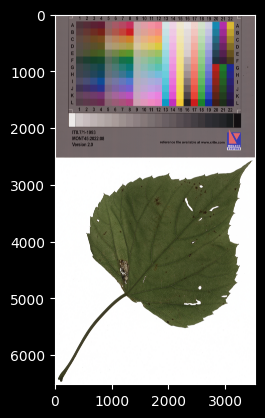

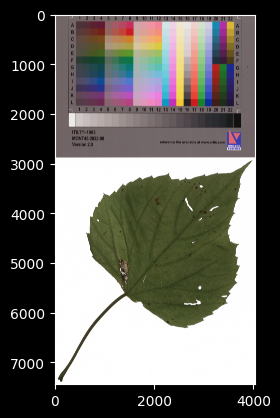

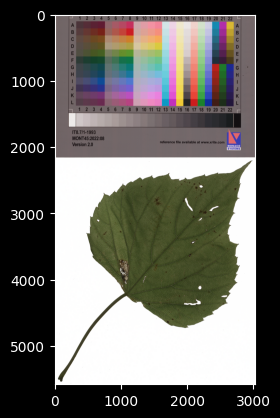

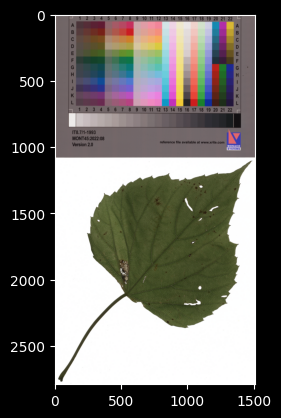

In [32]:
images = []
# plot image
for image_name in tqdm(image_names):
    image = Image.open(image_path + image_name)
    image = np.array(image) / 255
    images.append(image)
    plt.imshow(image)
    plt.show()

In [33]:
reload(TG)
# instantiate tile generator
train_generator = TG.TileGenerator(images = images,
                                   tile_size = 224,
                                   split = 'train',
                                   n_pad = 32
                                   )

val_generator = TG.TileGenerator(images = images,
                                 tile_size = 224,
                                 split = 'val',
                                 n_pad = 32)

Plotting training examples...


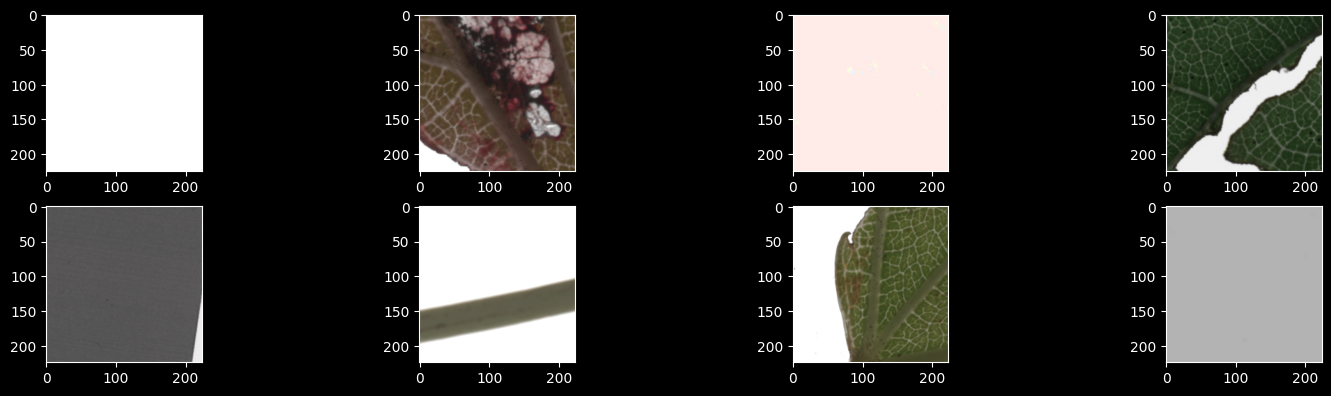

Plotting validation examples...


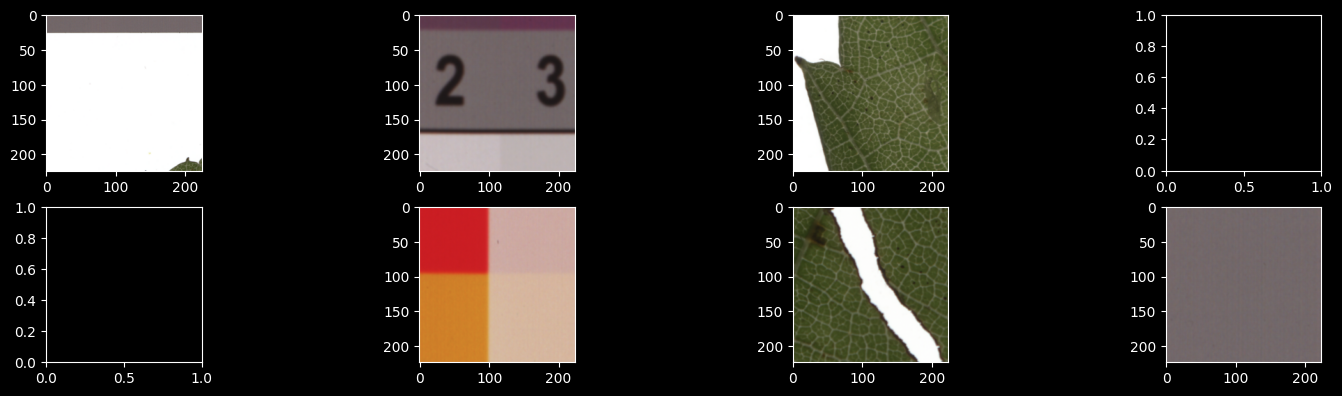

In [40]:
#plot
#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img = train_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()
    
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(img, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img = val_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()

    ax = fig.add_subplot(4, 4, i+1)

    try:
        plt.imshow(img, vmin=0, vmax=1)
    except ValueError:  #raised if `y` is empty.
        pass

plt.tight_layout(pad=0.5)
plt.show()

# Create Model

In [38]:
# instantiate w-net
reload(BuildWNet)
wnet = BuildWNet.WNet().to(device)

# test w/ random patch
# generate random patch 224 x 224 x 3
patch = torch.rand((1,3,224,224)).to(device)

out = wnet(patch)

# Define Loss Function

# Train Model